In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import inf

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
colnames=['timestamp', 'game_name', 'num_channels', 'num_viewers']

In [4]:
df=pd.read_csv('Natasha.csv',header =None, names = colnames)

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
df=df.sort_values(by=['game_name','timestamp'])

In [7]:
df.reset_index(inplace = True)

In [8]:
df.drop(columns='index',inplace = True)

# Smart "Diff()" to only find diff if game names are equivalent

In [9]:
#
# df['diff_channels'] = df['num_channels']
# df['diff_viewers'] = df['num_viewers']
# for row_index in range(1,df.shape[0]):
#     # 0 - time_logged
#     # 1 - game_name
#     # 2 - num_channels
#     # 3 - num_viewers
#     # 4 - diff_channels
#     # 5 - diff_viewers
    
    
#     # Check if game_name of this row and previous row are the same
#     if df.iloc[row_index,1] == df.iloc[row_index-1,1]:
#         df.iloc[row_index,4] = int(df.iloc[row_index,2] - df.iloc[row_index-1,2])
#         df.iloc[row_index,5] = int(df.iloc[row_index,3] - df.iloc[row_index-1,3])
#     else:
#     # If the game names are different, the difference between metrics is invalid, fill with NaN
#         df.iloc[row_index,4] = np.NaN
#         df.iloc[row_index,5] = np.NaN

In [10]:
df['diff_channels'] = df['num_channels']
df['diff_viewers'] = df['num_viewers']

In [11]:
df_values =  df.values

In [12]:
df_values[4,1]

' F1 2019'

In [13]:
for row_index in range(1,df.shape[0]):
    # 0 - time_logged
    # 1 - game_name
    # 2 - num_channels
    # 3 - num_viewers
    # 4 - diff_channels
    # 5 - diff_viewers
    
    
    # Check if game_name of this row and previous row are the same
    if df_values[row_index,1] == df_values[row_index-1,1]:
        df_values[row_index,4] = int(df_values[row_index,2] - df_values[row_index-1,2])
        df_values[row_index,5] = int(df_values[row_index,3] - df_values[row_index-1,3])
    else:
    # If the game names are different, the difference between metrics is invalid, fill with NaN
        df_values[row_index,4] = np.NaN
        df_values[row_index,5] = np.NaN

In [14]:
diff_df=pd.DataFrame(df_values).rename(columns={0: 'timestamp',
                                                1: 'game_name',
                                                2: 'num_channels',
                                                3: 'num_viewers',
                                                4: 'diff_channels',
                                                5: 'diff_viewers'})

In [15]:
diff_df.to_pickle('./sully_df_differences.pkl',compression = 'zip')

In [16]:
df=pd.read_pickle('./sully_df_differences.pkl',compression = 'zip')

In [17]:
df.shape

(2092036, 6)

In [21]:
LoL=df.loc[df['game_name'] == 'League of Legends']

In [22]:
LoL.drop(columns = ['timestamp','game_name', 'num_channels','num_viewers'])

,diff_channels,diff_viewers
938390,NaN,NaN
938391,-376,-16775
938392,-83,3915
938393,-14,6393
938394,-201,18045
938395,-216,-10105
938396,-259,330
938397,-227,-19222
938398,-142,3021
938399,49,-736


In [23]:
# timeseries_to_supervised(df)

# Jason Brownlee

LSTM Code

https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/

# Inspired by Tony's Code

In [25]:
LoL.head()

,timestamp,game_name,num_channels,num_viewers,diff_channels,diff_viewers
938390,2019-04-22 00:00:00,League of Legends,3160,97898,NaN,NaN
938391,2019-04-22 01:00:00,League of Legends,2784,81123,-376,-16775
938392,2019-04-22 02:00:00,League of Legends,2701,85038,-83,3915
938393,2019-04-22 03:00:00,League of Legends,2687,91431,-14,6393
938394,2019-04-22 04:00:00,League of Legends,2486,109476,-201,18045


In [170]:
# Necessary to prevent NaN loss function
LoL.dropna(inplace = True)

/anaconda3/envs/twitchrecommender/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [175]:
# pd.DataFrame(train_sample)

In [163]:
def slice_data(train_ratio,data_df, column_name ):
    # Divide into train set by cutting up dataframe using train_len
    true_test_size = 100
    train_len = int(data_df.shape[0] * (train_ratio))
    
    
    # Train data set (index 0 to the training length)
    train = data_df[column_name][1:train_len].copy()
    train.reset_index(inplace=True, drop=True)

    # Validation data set (index of end of training data up to the 'true test')
    test = data_df[column_name][train_len:-true_test_size].copy()
    test.reset_index(inplace=True, drop=True)
    
    # True test data set (index of end of validation dataset to end of entire dataset)
    true_test = data_df[column_name][-true_test_size:].copy()
    true_test.reset_index(inplace=True, drop=True)

    return train, test, true_test

In [ ]:
scaler-MinMaxScaler()

In [30]:
scaler=MinMaxScaler()
diff_data = LoL[['diff_channels','diff_viewers']].values
print(scaler.fit(diff_data))

MinMaxScaler(copy=True, feature_range=(0, 1))


In [31]:
LoL['diff_channels_scaled']=scaler.transform(diff_data)[:,0]
LoL['diff_viewers_scaled']=scaler.transform(diff_data)[:,1]

/anaconda3/envs/twitchrecommender/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/twitchrecommender/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
LoL.head()


,timestamp,game_name,num_channels,num_viewers,diff_channels,diff_viewers,diff_channels_scaled,diff_viewers_scaled
938391,2019-04-22 01:00:00,League of Legends,2784,81123,-376,-16775,0.139108,0.536666
938392,2019-04-22 02:00:00,League of Legends,2701,85038,-83,3915,0.395451,0.570331
938393,2019-04-22 03:00:00,League of Legends,2687,91431,-14,6393,0.455818,0.574362
938394,2019-04-22 04:00:00,League of Legends,2486,109476,-201,18045,0.292213,0.593321
938395,2019-04-22 05:00:00,League of Legends,2270,99371,-216,-10105,0.279090,0.547519


In [34]:
def make_variables(dataset, lags, look_back, predict_window):
    ''' dataset = np.matrix
        lags = integer, number of previous rows to include as features for predicting next
        look_back = integer, number of previous MODELS
        predict_window = integer, number of rows to predict ahead
    '''
    num_features = lags+1
    # starting index - Start at a point where we still have int(look_back) number of rows to look back
    start = look_back
    
    # total length - num previous rows to look at - num rows to predict
    stop = len(dataset) - lags - predict_window

    lstm_in_X = np.zeros(shape=(stop-start, look_back+1, num_features))
    lstm_in_Y = np.zeros(shape=(stop-start, look_back+1))

    iter_list = [num for num in range(look_back+1)][::-1]
    
    # Generating the features for the model (based on lags and look back)
    for i in range(start, stop):
        for index, j in enumerate(iter_list):
            X = dataset[i-j : i-j+lags+1, -1]
            lstm_in_X[i-start, index] = np.ravel(X)
            Y = dataset[i-j+lags+1, -1]
            lstm_in_Y[i-start, index] = Y
    return lstm_in_X, lstm_in_Y, num_features

In [103]:
test_in_X, test_in_Y,test_features = make_variables(np.matrix(LoL[['diff_channels_scaled']]), lags, look_back,predict_window)

In [153]:
len(test_in_X[0][0])

51

In [141]:
def train_lstm(train, feature_names, lags,
               look_back, predict_window,
               lstm_neurons, dense_layers
               , epochs = 100, batch_size = 10):
    dataset = np.matrix(train[feature_names])
    lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
    train_X = lstm_in_X
    train_Y = lstm_in_Y
    
    # Inputs travel from one layer to next
    model = Sequential()
    # LSTM layer 
    model.add(LSTM(lstm_neurons, input_shape=(look_back+1, features)))
    # Dropout of 20% to prevent overfitting
    model.add(Dropout(0.2))
    # Add linear stacked modeling layers with dropout 
    for neurons in dense_layers:
        model.add(Dense(neurons))
        model.add(Dropout(0.2))
    
    # For output, we need to output the number of previous models and our current model
    model.add(Dense(look_back+1))
    
    # Choose loss function and optimizer
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(train_X, train_Y,batch_size = batch_size, epochs = epochs, verbose=1)
    
    pred_Y_train = model.predict(train_X)
    # Every look back model is outputting a prediction for the next day, so we look at the LAST one to
    # get the predictions for days that are out of that batch
    predictions = pred_Y_train[:,-1]
    
    actuals = train_Y[:,-1]
    
    print(model.summary())
    
    return model, dataset, train_X, train_Y, predictions, actuals

In [222]:
# Main - for running the pipeline

train_perc = 0.40
# How many points to look back - 168 = 24 hours/day * 7 days / week 
lags = 50
look_back = 24       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
# List of integers, each corresponding to the number of neurons in N dense layers,
# where N is the number of integers
dense_layers = []
epochs= 300
batch_size = 10

In [176]:
train_sample,test_sample,true_test_sample = slice_data(.7,LoL,['diff_channels'])

In [230]:
def test_lstm(test_df, feature_names, model): 
    dataset = np.matrix(test_df[feature_names])
    lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
    pred_Y_train = model.predict(lstm_in_X)
    # Every look back model is outputting a prediction for the next day, so we look at the LAST one to
    # get the predictions for days that are out of that batch
    predictions = pred_Y_train[:,-1]
    actuals = lstm_in_Y[:,-1]
    return predictions, actuals


In [232]:
test_predictions, test_actuals = test_lstm(test_sample,['diff_channels'],model)

In [224]:
model, dataset, train_X, train_Y, predictions, actuals = \
train_lstm(train_sample,['diff_channels'],lags, look_back,predict_window,lstm_neurons,dense_layers,epochs,batch_size)

Epoch 1/300
579/579 [==============================] - 9s 15ms/step - loss: 39877.3080
Epoch 2/300
579/579 [==============================] - 3s 6ms/step - loss: 39342.7884
Epoch 3/300
579/579 [==============================] - 3s 6ms/step - loss: 38746.2789
Epoch 4/300
579/579 [==============================] - 3s 6ms/step - loss: 38116.0976
Epoch 5/300
579/579 [==============================] - 3s 6ms/step - loss: 37476.5219
Epoch 6/300
579/579 [==============================] - 4s 6ms/step - loss: 36868.3615
Epoch 7/300
579/579 [==============================] - 3s 6ms/step - loss: 36242.5404
Epoch 8/300
579/579 [==============================] - 4s 6ms/step - loss: 35636.1513
Epoch 9/300
579/579 [==============================] - 4s 6ms/step - loss: 35026.2174
Epoch 10/300
579/579 [==============================] - 4s 6ms/step - loss: 34413.2003
Epoch 11/300
579/579 [==============================] - 3s 6ms/step - loss: 33846.0923
Epoch 12/300
579/579 [=============================

579/579 [==============================] - 3s 6ms/step - loss: 13734.8027
Epoch 96/300
579/579 [==============================] - 3s 6ms/step - loss: 13636.8435
Epoch 97/300
579/579 [==============================] - 3s 6ms/step - loss: 13579.6210
Epoch 98/300
579/579 [==============================] - 3s 6ms/step - loss: 13526.9488
Epoch 99/300
579/579 [==============================] - 3s 6ms/step - loss: 13443.5791
Epoch 100/300
579/579 [==============================] - 3s 6ms/step - loss: 13421.8508
Epoch 101/300
579/579 [==============================] - 3s 6ms/step - loss: 13369.7788
Epoch 102/300
579/579 [==============================] - 3s 6ms/step - loss: 13300.5109
Epoch 103/300
579/579 [==============================] - 4s 6ms/step - loss: 13210.1879
Epoch 104/300
579/579 [==============================] - 3s 6ms/step - loss: 13142.0030
Epoch 105/300
579/579 [==============================] - 3s 6ms/step - loss: 13061.7395
Epoch 106/300
579/579 [===========================

579/579 [==============================] - 3s 6ms/step - loss: 9844.7316
Epoch 189/300
579/579 [==============================] - 3s 6ms/step - loss: 9784.0388
Epoch 190/300
579/579 [==============================] - 3s 6ms/step - loss: 9755.1631
Epoch 191/300
579/579 [==============================] - 3s 6ms/step - loss: 9797.3591
Epoch 192/300
579/579 [==============================] - 3s 6ms/step - loss: 9717.3128
Epoch 193/300
579/579 [==============================] - 3s 6ms/step - loss: 9643.0124
Epoch 194/300
579/579 [==============================] - 3s 6ms/step - loss: 9658.8656
Epoch 195/300
579/579 [==============================] - 3s 6ms/step - loss: 9648.0742
Epoch 196/300
579/579 [==============================] - 3s 6ms/step - loss: 9612.0784
Epoch 197/300
579/579 [==============================] - 3s 6ms/step - loss: 9589.5492
Epoch 198/300
579/579 [==============================] - 3s 6ms/step - loss: 9509.9250
Epoch 199/300
579/579 [==============================] - 

579/579 [==============================] - 3s 6ms/step - loss: 7885.3281
Epoch 283/300
579/579 [==============================] - 3s 6ms/step - loss: 7892.5161
Epoch 284/300
579/579 [==============================] - 3s 6ms/step - loss: 7939.2043
Epoch 285/300
579/579 [==============================] - 4s 7ms/step - loss: 7892.4339
Epoch 286/300
579/579 [==============================] - 4s 7ms/step - loss: 7836.7271
Epoch 287/300
579/579 [==============================] - 4s 7ms/step - loss: 7892.1755
Epoch 288/300
579/579 [==============================] - 4s 7ms/step - loss: 7756.5466
Epoch 289/300
579/579 [==============================] - 4s 7ms/step - loss: 7740.6153
Epoch 290/300
579/579 [==============================] - 4s 6ms/step - loss: 7790.2015
Epoch 291/300
579/579 [==============================] - 4s 7ms/step - loss: 7782.7780
Epoch 292/300
579/579 [==============================] - 4s 7ms/step - loss: 7721.8267
Epoch 293/300
579/579 [==============================] - 

In [215]:
len(predictions)

598

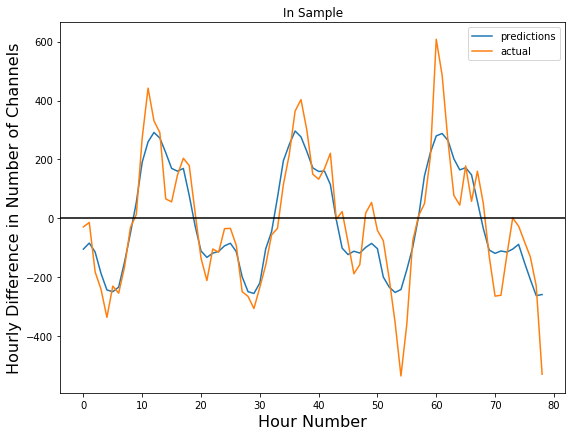

In [243]:
predictions_test = predictions
actuals_test = actuals
lower_lim = 500
upper_lim = len(predictions)
fig, ax = plt.subplots(figsize=(8,6))
# Set background of area behind axis labels
fig.patch.set_facecolor('white')

ax.set_xlabel('Hour Number', fontsize=16)
ax.set_ylabel('Hourly Difference in Number of Channels',fontsize=16)
plt.tight_layout()
plt.plot(predictions[lower_lim:upper_lim]);
plt.plot(actuals[lower_lim:upper_lim]);
# plt.plot(actuals)
plt.title('In Sample')
plt.axhline(y=0, color='black');
plt.legend(['predictions','actual'])
plt.show()

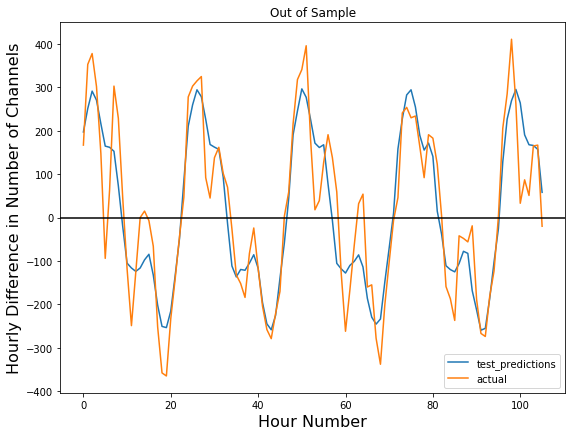

In [244]:

lower_lim = 0
upper_lim = len(test_predictions)
fig, ax = plt.subplots(figsize=(8,6))
# Set background of area behind axis labels
fig.patch.set_facecolor('white')

ax.set_xlabel('Hour Number', fontsize=16)
ax.set_ylabel('Hourly Difference in Number of Channels',fontsize=16)
plt.tight_layout()
plt.plot(test_predictions[lower_lim:upper_lim]);
plt.plot(test_actuals[lower_lim:upper_lim]);
# plt.plot(test_actuals)
plt.axhline(y=0, color='black');
plt.legend(['test_predictions','actual'])
plt.title('Out of Sample')
plt.show()

In [217]:
np.sqrt(np.sum(np.square([5, 5, 2, 1])))

7.416198487095663

In [226]:
def rmse(predicted,actuals):
    assert len(predicted) == len(actuals)
    residuals = predicted-actuals
    return np.sqrt(np.sum(np.square(residuals)))

In [227]:
np.sum(predictions-actuals)/len(predictions)


-0.15856239683475726

In [228]:
rmse(predictions,actuals)

1942.8350957215114

In [229]:
test_sample

,diff_channels
0,-379
1,-76
2,202
3,352
4,351
5,383
6,291
7,50
8,28
9,111
